In [33]:
#案例2：社交媒体用户增长预测 -Logistic增长模型的非线性回归实现
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#设置中文字体与样式
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.set_style("darkgrid")  # 设置seaborn样式

In [34]:
print("=" * 60)
print("案例2：社交媒体用户增长预测")
print("基于Logistic增长模型的非线性回归实现")
print("=" * 60)

案例2：社交媒体用户增长预测
基于Logistic增长模型的非线性回归实现


##### 1.数据生成 - 模拟真实社交媒体用户增长

In [35]:
#1.数据生成 - 模拟真实社交媒体用户增长
def generate_social_media_data(n_months = 18, noise_level = 0.08):
    """生成模拟社交媒体用户增长数据"""
    np.random.seed(123)  # 设置随机种子以确保可重复性
    
    #时间序列（月份）
    months = np.arange(1, n_months + 1)
    
    #真实的Logistic增长参数
    L = 1000000  # 最大用户数（100万）
    k = 0.6  # 增长率
    x0 = 8  # 拐点时间（第8个月）
    
    #基础Logistic增长
    base_users =L / (1 + np.exp(-k * (months - x0)))
    
    #添加季节性变化（模拟节假日效应）
    seasonal_factor = 1 + 0.1 * np.sin(2 * np.pi * months / 12)  # 每年周期性波动
    
    #添加营销活动影响（在第4、9、14个月）
    marketing_boost = np.zeros_like(months, dtype = float)
    marketing_months = [4, 9, 14]
    for month in marketing_months:
        if month <= len(months):
            #营销活动产生2个月的影响
            start_idx = month - 1
            end_idx = min(month + 1, len(months))
            boost_factor = np.exp(-(np.arange(start_idx, end_idx) - start_idx) / 2)
            marketing_boost[start_idx:end_idx] += 0.15 * boost_factor
            
    #综合影响
    true_users = base_users * seasonal_factor * (1 + marketing_boost)
    
    #添加随机噪声
    noise = np.random.normal(0, noise_level * true_users, len(months))
    observed_users = true_users + noise
    
    #确保用户数为非负整数
    observed_users = np.maximum(observed_users, 0)
    
    return months, observed_users, true_users, base_users, (L, k, x0)

#生成数据
months, observed_users, true_users, base_users, true_params = generate_social_media_data(n_months = 20)

#创建综合数据库
df = pd.DataFrame({
    '月份': months,
    '观察用户数': observed_users.astype(int),
    '真实用户数': true_users.astype(int),
    '基础增长': base_users.astype(int),
    '增长率(%)': np.append([0], np.diff(observed_users) / observed_users[:-1] * 100),
    '月增长量': np.append([0], np.diff(observed_users).astype(int))
})

print("\n 社交媒体用户增长数据预览：")
print(df.head(12))

print("\n 数据统计信息:")
print(f"观察周期：{months.min()}-{months.max()}个月")
print(f"用户数范围：{observed_users.min()/1000:.0f}K-{observed_users.max()/1000:.0f}K")
print(f"最大月增长：{df['月增长量'].max()/1000:.0f}K")
print(f"平均月增长率：{df['增长率(%)'][1:].mean():.1f}%")

    
    


 社交媒体用户增长数据预览：
    月份   观察用户数   真实用户数    基础增长      增长率(%)    月增长量
0    1   14165   15512   14774    0.000000       0
1    2   31206   28900   26596  120.298418   17040
2    3   53349   52168   47425   70.957615   22143
3    4   91407  103932   83172   71.337864   38058
4    5  154972  162494  141851   69.540067   63565
5    6  262056  231475  231475   69.098302  107083
6    7  271275  336626  354343    3.518018    9219
7    8  441028  456698  500000   62.575546  169752
8    9  735931  668254  645656   66.867325  294903
9   10  712731  765833  768524   -3.152542  -23200
10  11  770964  815241  858148    8.170527   58233
11  12  909880  916827  916827   18.018427  138915

 数据统计信息:
观察周期：1-20个月
用户数范围：14K-1230K
最大月增长：295K
平均月增长率：29.8%


##### 2.数据探索性分析

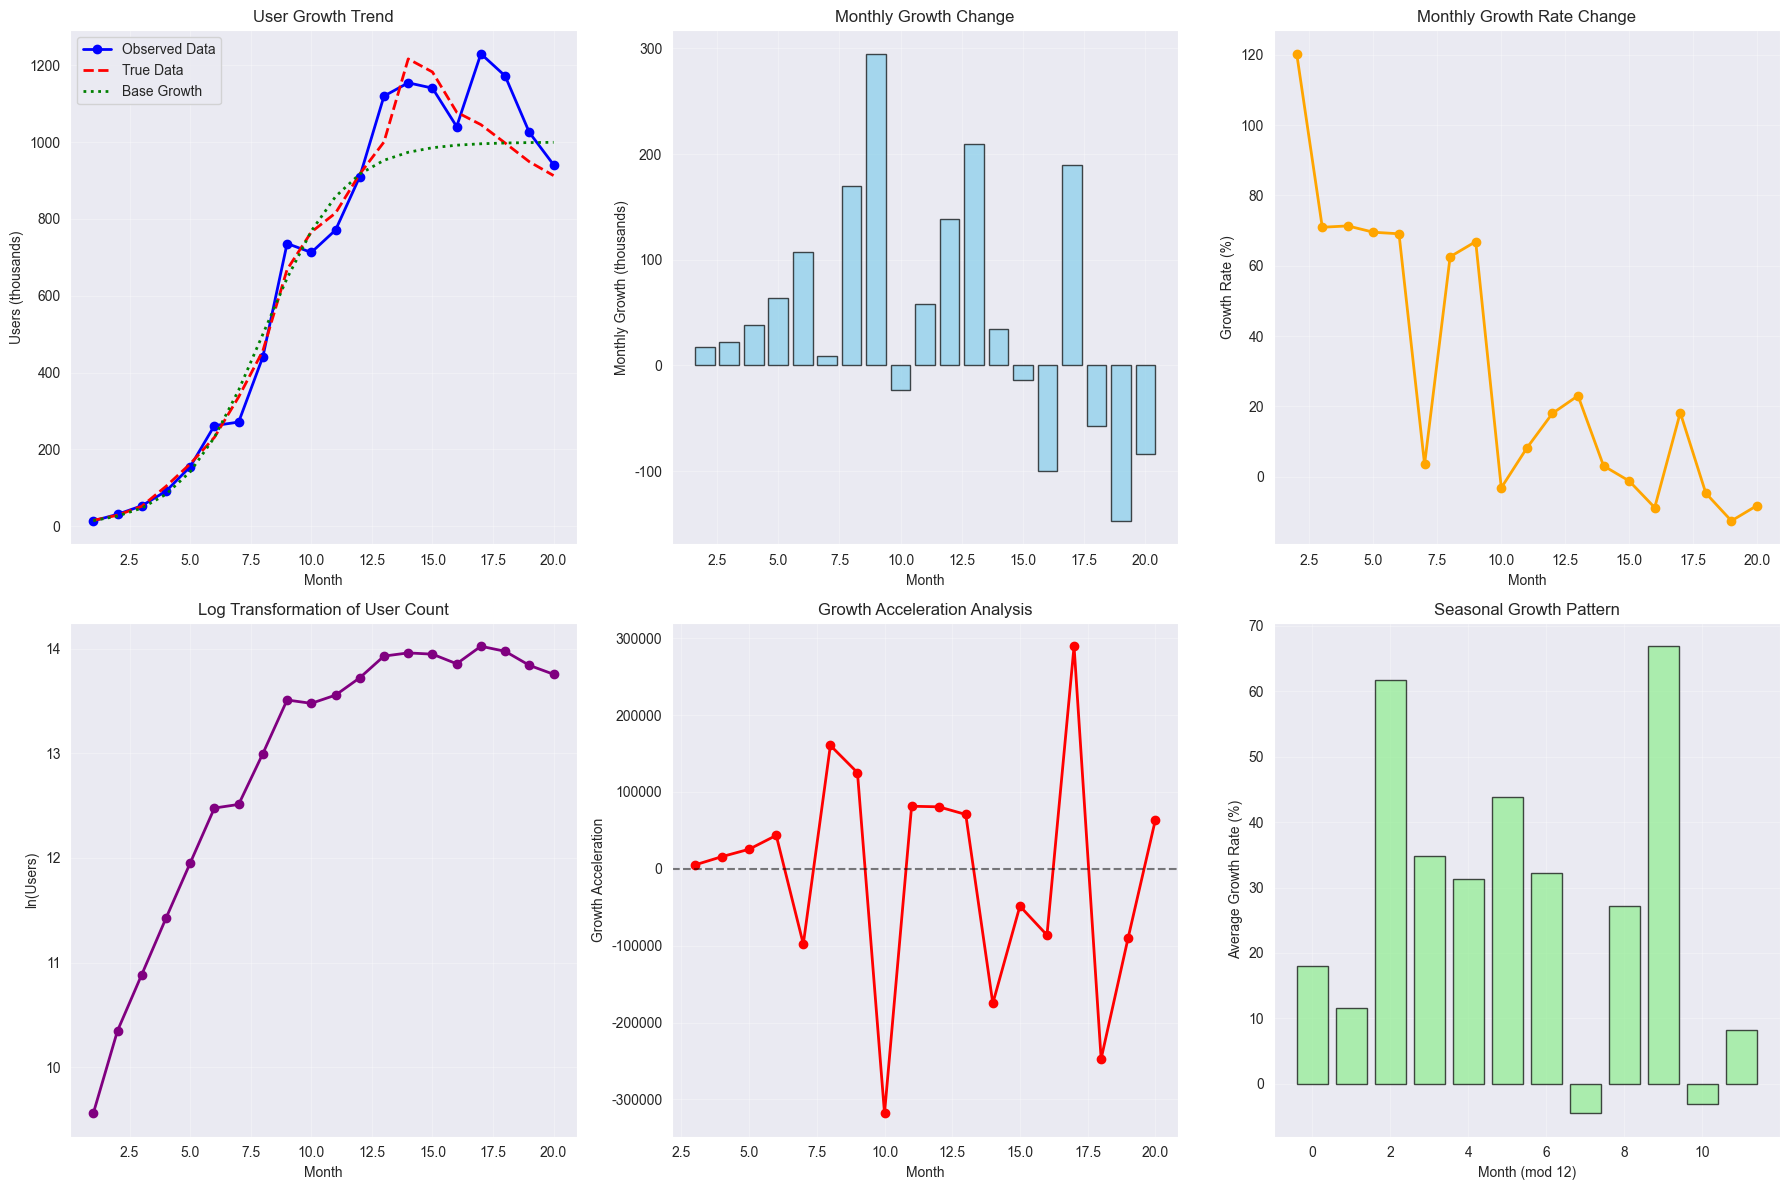

In [36]:
# 2. Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# User growth trend
axes[0, 0].plot(months, observed_users/1000, 'o-', color='blue', linewidth=2, markersize=6, label='Observed Data')
axes[0, 0].plot(months, true_users/1000, '--', color='red', linewidth=2, label='True Data')
axes[0, 0].plot(months, base_users/1000, ':', color='green', linewidth=2, label='Base Growth')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Users (thousands)')
axes[0, 0].set_title('User Growth Trend')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Monthly growth change
axes[0, 1].bar(months[1:], df['月增长量'][1:]/1000, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Monthly Growth (thousands)')
axes[0, 1].set_title('Monthly Growth Change')
axes[0, 1].grid(True, alpha=0.3)

# Growth rate change
axes[0, 2].plot(months[1:], df['增长率(%)'][1:], 'o-', color='orange', linewidth=2, markersize=6)
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Growth Rate (%)')
axes[0, 2].set_title('Monthly Growth Rate Change')
axes[0, 2].grid(True, alpha=0.3)

# Log transformation of user count
axes[1, 0].plot(months, np.log(observed_users), 'o-', color='purple', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('ln(Users)')
axes[1, 0].set_title('Log Transformation of User Count')
axes[1, 0].grid(True, alpha=0.3)

# Growth acceleration (second derivative)
growth_acceleration = np.diff(df['月增长量'][1:])
axes[1, 1].plot(months[2:], growth_acceleration, 'o-', color='red', linewidth=2, markersize=6)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Growth Acceleration')
axes[1, 1].set_title('Growth Acceleration Analysis')
axes[1, 1].grid(True, alpha=0.3)

# Seasonal analysis
monthly_avg = df.groupby(df['月份'] % 12)['增长率(%)'].mean()
axes[1, 2].bar(monthly_avg.index, monthly_avg.values, color='lightgreen', edgecolor = 'black',alpha=0.7)
axes[1, 2].set_xlabel('Month (mod 12)')
axes[1, 2].set_ylabel('Average Growth Rate (%)')
axes[1, 2].set_title('Seasonal Growth Pattern')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### 3. 定义多种非线性模型

# 非线性增长模型数学公式

## 1. 标准Logistic增长模型

$$f(x) = \frac{L}{1 + e^{-k(x - x_0)}}$$

**参数说明：**
- $L$: 最大承载量（饱和值）
- $k$: 增长率参数
- $x_0$: 拐点位置（增长最快的点）

---

## 2. 修正的Logistic模型

$$f(x) = c + \frac{L - c}{1 + e^{-k(x - x_0)}}$$

**参数说明：**
- $c$: 基础用户数（初始偏移量）
- $L$: 最大承载量
- $k$: 增长率参数
- $x_0$: 拐点位置

---

## 3. Gompertz增长模型

$$f(x) = L \cdot e^{-e^{-k(x - x_0)}}$$

**参数说明：**
- $L$: 最大承载量（渐近上限）
- $k$: 增长率参数
- $x_0$: 拐点位置

**特点：** 增长曲线不对称，前期增长较慢，后期趋于平缓

---

## 4. Richards增长模型（广义Logistic）

$$f(x) = L \cdot \left(1 + \nu \cdot e^{-k(x - x_0)}\right)^{-\frac{1}{\nu}}$$

**参数说明：**
- $L$: 最大承载量
- $k$: 增长率参数
- $x_0$: 拐点位置
- $\nu$: 形状参数（控制曲线不对称性）

**特殊情况：**
- 当 $\nu = 1$ 时，退化为标准Logistic模型
- 当 $\nu \to 0$ 时，趋近于Gompertz模型

---

## 5. Bass扩散模型

$$f(x) = m \cdot \frac{1 - e^{-(p + q)x}}{1 + \frac{q}{p} \cdot e^{-(p + q)x}}$$

**参数说明：**
- $m$: 市场潜力（最终采用者总数）
- $p$: 创新系数（外部影响，如广告）
- $q$: 模仿系数（内部影响，如口碑传播）

**特点：** 专门用于建模新产品或技术的市场扩散过程

---

## 模型比较

| 模型 | 对称性 | 拐点位置 | 适用场景 |
|------|--------|----------|----------|
| Logistic | 对称 | $x_0$ | 生物增长、用户增长 |
| 修正Logistic | 对称 | $x_0$ | 有基础用户的增长 |
| Gompertz | 不对称 | 偏前 | 肿瘤生长、技术采用 |
| Richards | 可调节 | $x_0$ | 通用增长建模 |
| Bass | 不对称 | 动态 | 产品扩散、创新传播 |

In [37]:
# 3. 定义多种非线性模型
def logistic_growth(x, L, k, x0):
    """
    标准Logistic增长模型
    L: 最大承载量
    k: 增长率
    x0: 拐点位置
    """
    return L / (1 + np.exp(-k * (x - x0)))

def modified_logistic(x, L, k, x0, c):
    """
    修正的Logistic模型（含基础用户）
    c: 基础用户数
    """
    return c + (L - c) / (1 + np.exp(-k * (x - x0)))

def gompertz_growth(x, L, k, x0):
    """
    Gompertz增长模型
    """
    return L * np.exp(-np.exp(-k * (x - x0)))

def richards_growth(x, L, k, x0, nu):
    """
    Richards增长模型（广义logistic）
    nu: 形状参数
    """
    return L * (1 + nu * np.exp(-k * (x - x0)))**(-1/nu)

def bass_diffusion(x, m, p, q):
    """
    Bass扩散模型
    m: 市场潜力
    p: 创新系数
    q: 模仿系数
    """
    return m * (1 - np.exp(-(p + q) * x)) / (1 + (q/p) * np.exp(-(p + q) * x))
def baye_ffun():
    return True

##### 4. 模型拟合与比较

In [38]:
print("\n🔧 多模型拟合比较")
print("-" * 50)

models = {
    'Logistic': {
        'func': logistic_growth,
        'initial': [800000, 0.5, 8],
        'bounds': ([100000, 0.1, 1], [2000000, 2.0, 15])
    },
    'Modified Logistic': {
        'func': modified_logistic,
        'initial': [800000, 0.5, 8, 10000],
        'bounds': ([100000, 0.1, 1, 0], [2000000, 2.0, 15, 100000])
    },
    'Gompertz': {
        'func': gompertz_growth,
        'initial': [800000, 0.5, 8],
        'bounds': ([100000, 0.1, 1], [2000000, 2.0, 15])
    }
}

# 存储拟合结果
results = {}
predictions = {}

for name, model_info in models.items():
    print(f"\n拟合 {name} 模型:")
    
    try:
        # 参数拟合
        popt, pcov = curve_fit(
            model_info['func'], 
            months, 
            observed_users,
            p0=model_info['initial'],
            bounds=model_info['bounds'],
            maxfev=10000
        )
        
        # 预测
        y_pred = model_info['func'](months, *popt)
        
        # 计算评估指标
        r2 = r2_score(observed_users, y_pred)
        rmse = np.sqrt(mean_squared_error(observed_users, y_pred))
        mae = mean_absolute_error(observed_users, y_pred)
        
        # 计算AIC和BIC
        n = len(observed_users)
        k = len(popt)
        mse = mean_squared_error(observed_users, y_pred)
        aic = n * np.log(mse) + 2 * k
        bic = n * np.log(mse) + k * np.log(n)
        
        # 参数标准误差
        param_std = np.sqrt(np.diag(pcov))
        
        # 存储结果
        results[name] = {
            'params': popt,
            'param_std': param_std,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'aic': aic,
            'bic': bic
        }
        
        predictions[name] = y_pred
        
        print(f"  参数: {popt}")
        print(f"  R²: {r2:.4f}")
        print(f"  RMSE: {rmse/1000:.1f}K")
        print(f"  MAE: {mae/1000:.1f}K")
        print(f"  AIC: {aic:.1f}")
        print(f"  BIC: {bic:.1f}")
        
    except Exception as e:
        print(f"  拟合失败: {e}")
        continue


🔧 多模型拟合比较
--------------------------------------------------

拟合 Logistic 模型:
  参数: [1.11578104e+06 5.41684081e-01 8.60621983e+00]
  R²: 0.9690
  RMSE: 77.1K
  MAE: 61.8K
  AIC: 456.1
  BIC: 459.1

拟合 Modified Logistic 模型:
  参数: [1.11425356e+06 5.53783374e-01 8.65411220e+00 1.10662066e+04]
  R²: 0.9691
  RMSE: 77.0K
  MAE: 62.2K
  AIC: 458.0
  BIC: 462.0

拟合 Gompertz 模型:
  参数: [1.14128300e+06 3.61365171e-01 7.44273049e+00]
  R²: 0.9628
  RMSE: 84.4K
  MAE: 74.5K
  AIC: 459.8
  BIC: 462.7


##### 5. 模型选择与比较

In [39]:
print("\n📊 模型比较总结")
print("-" * 50)

# 创建比较表
comparison_df = pd.DataFrame({
    name: {
        'R²': results[name]['r2'],
        'RMSE(K)': results[name]['rmse']/1000,
        'MAE(K)': results[name]['mae']/1000,
        'AIC': results[name]['aic'],
        'BIC': results[name]['bic']
    }
    for name in results.keys()
}).round(4)

print("模型性能比较:")
print(comparison_df)

# 找出最佳模型
best_model = min(results.keys(), key=lambda x: results[x]['bic'])
print(f"\n最佳模型（基于BIC）: {best_model}")


📊 模型比较总结
--------------------------------------------------
模型性能比较:
         Logistic  Modified Logistic  Gompertz
R²         0.9690             0.9691    0.9628
RMSE(K)   77.0502            76.9702   84.4454
MAE(K)    61.8085            62.1836   74.4740
AIC      456.0885           458.0470  459.7544
BIC      459.0757           462.0299  462.7416

最佳模型（基于BIC）: Logistic


##### 6. 最佳模型的详细分析

In [40]:
print(f"\n🏆 {best_model} 模型详细分析")
print("-" * 50)

best_params = results[best_model]['params']
best_param_std = results[best_model]['param_std']

if best_model == 'Logistic':
    print(f"最大用户数 (L): {best_params[0]/1000:.1f}K ± {best_param_std[0]/1000:.1f}")


🏆 Logistic 模型详细分析
--------------------------------------------------
最大用户数 (L): 1115.8K ± 36.5
